# Stacking


### ver1
feature : 'oof_lgb', 'oof_xgb', 'oof_catboost', 'oof_tabnet'  
model   : logistic regression  

CV : 0.79733
LB : 0.796

### ver2
feature : 上記＋’lgb_exp01_oof’、’lgb_exp03_oof’ 
model   : logistic regression  


In [1]:
# CFG

class CFG:
    exp = "exp20"
    seed = 614
    model = "svc"

pycaret_sw = False

# Main pycaret
if pycaret_sw:
    !pip install --ignore-installed pycaret


In [2]:
##
import os
import random
import time
import psutil
import gc

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import KFold, StratifiedKFold
import optuna
from sklearn.ensemble import StackingClassifier

import pickle

from sklearn.ensemble import RandomForestClassifier
from sklearn.calibration import CalibratedClassifierCV
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import RidgeClassifier
from sklearn.svm import LinearSVC
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.ensemble import StackingClassifier
from sklearn.svm import SVC
from sklearn.linear_model import Perceptron
import lightgbm as lgb
import seaborn as sns


#現在の最大表示列数の出力
pd.get_option("display.max_columns")

#最大表示列数の指定（ここでは50列を指定）
pd.set_option('display.max_columns', 100)
# import torch
# from torch import nn
# from pytorch_tabnet.tab_model import TabNetClassifier
# from pytorch_tabnet.metrics import Metric
# from torch.nn import functional as F


# 評価指標

In [3]:
def amex_metric_mod(y_true, y_pred):

    labels     = np.transpose(np.array([y_true, y_pred]))
    labels     = labels[labels[:, 1].argsort()[::-1]]
    weights    = np.where(labels[:,0]==0, 20, 1)
    cut_vals   = labels[np.cumsum(weights) <= int(0.04 * np.sum(weights))]
    top_four   = np.sum(cut_vals[:,0]) / np.sum(labels[:,0])

    gini = [0,0]
    for i in [1,0]:
        labels         = np.transpose(np.array([y_true, y_pred]))
        labels         = labels[labels[:, i].argsort()[::-1]]
        weight         = np.where(labels[:,0]==0, 20, 1)
        weight_random  = np.cumsum(weight / np.sum(weight))
        total_pos      = np.sum(labels[:, 0] *  weight)
        cum_pos_found  = np.cumsum(labels[:, 0] * weight)
        lorentz        = cum_pos_found / total_pos
        gini[i]        = np.sum((lorentz - weight_random) * weight)

    return 0.5 * (gini[1]/gini[0] + top_four)

# データ取得

In [4]:
## OOF
tabnet_oof = pd.read_csv('../input/amex-oof/tabnet_oof.csv').rename(columns={"oof":"tabnet_oof"})

cat_oof = pd.read_csv('../input/amex-catboost-cv-0792297/oof_cat_0.7922979431238725.csv').drop("Unnamed: 0",axis = 1)

tab_oof2 = pd.read_csv('../input/amex-tabnetclassifier-feature-eng-2/tabnet_435feat_0.78836_oof.csv')
xgb_oof = pd.read_csv('../input/rapids-cudf-feature-engineeringxgb-cv0793904/xgb_584feat_0.0008387144613055545_oof.csv')
lgb_oof = pd.read_csv('../input/amex-lightgbm-quickstart-cv07942/lgb_469feat_07942_oof.csv')

# ver2umn
lgb_exp01_oof = pd.read_csv('../input/exp01-local-lag-features-are-all-you-need/oof_lgbm_baseline_5fold_seed45.csv').drop("target",axis = 1).rename(columns={'prediction': 'oof_lgb_exp01'})
lgb_exp03_oof = pd.read_csv('../input/exp03-local-amex-lgbm-dart-cv-07977/oof_lgbm_dart_baseline_5fold_seed42.csv').drop("target",axis = 1).rename(columns={'prediction': 'oof_lgb_exp03'})

#ver1.T
gru_oof = pd.read_csv('../input/yoshiki01-gru-oof/GRU_oof.csv').rename(columns={'pred': 'oof_gru'}).drop(columns='target')

#ver2.T
exp37_oof = pd.read_csv('../input/exp37-xgb-lagdiff-c3/oof_exp37_xgb_0.794857198067441_5fold_seed42.csv').drop("target",axis = 1).rename(columns={'tabnet_oot': 'exp37_xgb_oof'})
# exp40_oof = pd.read_csv('../input/exp40-lgb-laggdiff-c3/oof_exp40_lgb_0.7969750332783205_5fold_seed42.csv').drop("target",axis = 1).rename(columns={'tabnet_oot': 'exp40_lgb_oof'})
exp40_oof = pd.read_csv('../input/exp40-lgb-seedblending/exp40_oof_lgb_0.7975318_seedblend.csv').rename(columns = {"exp42+49_oof":"exp40_seedblend_oof"})


exp41_oof = pd.read_csv('../input/exp41-cat-laggdiff-c3/oof_exp41_cat_0.7948423257935038_5fold_seed42.csv').drop("target",axis = 1)
# exp42_oof = pd.read_csv('../input/exp42-logistic-seedblending/exp42_oof_logist_0.7828114243647253_seedblend.csv')
exp42_oof = pd.read_csv('../input/exp42-3-logistic-lagdiff-c3/oof_exp42_3_logistic_0.782316702096232_5fold_seed42.csv').drop("target",axis = 1)
# exp43_oof = pd.read_csv('../input/exp43-xgb-seedblend/exp43_oof_xgb_0.7949781307720436_seedblend.csv')
exp43_oof = pd.read_csv('../input/exp43-xgb-lagdiff-c3/oof_exp43_xgb_0.7956869117243499_5fold_seed42.csv').drop(["Unnamed: 0","target"],axis = 1).rename(columns={'tabnet_oot': 'exp43_oof'})

exp21_oof = pd.read_csv('../input/exp21-deeptab-seedblend/exp21_oof_deeptab_0.7895385189225891_seedblend.csv')
lstm_oof = pd.read_csv('../input/yoshiki-lstm/LSTM_oof.csv').rename(columns={'pred': 'oof_lstm'}).drop(columns='target')


## Sub
tabnet_sub = pd.read_csv('../input/amex-sub/tabnet_sub.csv')
cat_sub = pd.read_csv('../input/amex-catboost-cv-0792297/submission_cat_0.7922979431238725.csv')
tab_sub2 = pd.read_csv('../input/amex-tabnetclassifier-feature-eng-2/submission_tabnet.csv')
xgb_sub = pd.read_csv('../input/rapids-cudf-feature-engineeringxgb-cv0793904/xgb_sub.csv')
lgb_sub = pd.read_csv('../input/amex-lightgbm-quickstart-cv07942/lgb_469feat_07942_sub.csv')

## ver2
lgb_exp01_sub = pd.read_csv('../input/exp01-local-lag-features-are-all-you-need/test_lgbm_baseline_5fold_seed45.csv').rename(columns={'prediction': 'lgb_exp01_pred'})
lgb_exp03_sub = pd.read_csv('../input/exp03-local-amex-lgbm-dart-cv-07977/test_lgbm_dart_baseline_5fold_seed42.csv').rename(columns={'prediction': 'lgb_exp03_pred'})

#ver1.T
gru_sub = pd.read_csv('../input/yoshiki01-gru-oof/submission.csv').rename(columns={'prediction': 'gru_pred'})

#ver2.T
exp37_sub = pd.read_csv('../input/exp37-xgb-lagdiff-c3/test_exp37_xgb_0.794857198067441_5fold_seed42.csv').rename(columns={'prediction': "exp37_sub"})
# exp40_sub = pd.read_csv('../input/exp40-lgb-laggdiff-c3/test_exp40_lgb_0.7969750332783205_5fold_seed42.csv').rename(columns={'prediction': 'exp40_sub'})
exp40_sub = pd.read_csv('../input/exp40-lgb-seedblending/exp40_sub_lgb_0.7975318_seedblend.csv').rename(columns={'prediction': 'exp40_seedblend_sub'})

exp41_sub = pd.read_csv('../input/exp41-cat-laggdiff-c3/test_exp41_cat_0.7948423257935038_5fold_seed42.csv').rename(columns={'prediction': 'exp41_sub'})
# exp42_sub = pd.read_csv('../input/exp42-logistic-seedblending/exp42_sub_logist_0.7828114243647253_seedblend.csv').rename(columns={'prediction': 'exp42_seedblend_sub'})
exp42_sub = pd.read_csv('../input/exp42-3-logistic-lagdiff-c3/test_exp42_3_logistic_0.782316702096232_5fold_seed42.csv').rename(columns={'prediction': 'exp42_sub'})
# exp43_sub = pd.read_csv('../input/exp43-xgb-seedblend/exp43_sub_xgb_0.7949781307720436_seedblend.csv').rename(columns={'prediction': 'exp43_seedblend_sub'})
exp43_sub = pd.read_csv('../input/exp43-xgb-lagdiff-c3/test_exp43_xgb_0.7956869117243499_5fold_seed42.csv').rename(columns={'prediction': 'exp43_sub'})
exp21_sub = pd.read_csv('../input/exp21-deeptab-seedblend/exp21_sub_deeptab_0.7895385189225891_seedblend.csv').rename(columns={'prediction': 'exp21_seedblend_sub'})
lstm_sub = pd.read_csv('../input/yoshiki-lstm/submission.csv').rename(columns={'prediction': 'lstm_pred'})

# # xgb_sub = pd.read_csv('../input/amex-sub/submission_xgb_v3.csv')
# lgb_sub = pd.read_csv('../input/amex-sub/lgb_sub_ver5.csv')

In [5]:
# exp46_oof = pd.read_csv('../input/exp46-xgb-pyramid/esp46_oof_xgb_pyramid_0.7965160043305448.csv').rename(columns={'oof_pred': "exp46_xgb_oof"}).drop('target',axis =1)
# exp46_sub = pd.read_csv('../input/exp46-xgb-pyramid/esp46_test_xgb_pyramid_0.7965160043305448.csv').rename(columns={'prediction': 'exp46_sub'})

xgb_pyrmd_oof = pd.read_csv('../input/amex-xgb-pyramid/oof.csv').drop("target",axis = 1).rename(columns={'oof_pred': 'xgb_pyrmd_oof'})
xgb_pyrmd_sub = pd.read_csv('../input/amex-xgb-pyramid/submission.csv').rename(columns={'prediction': 'xgb_pyrmd_sub'})

exp51_oof = pd.read_csv('../input/exp51-lgb-seedblending/exp51_oof_lgb_0.7977581573285044_seedblend.csv')
exp51_sub = pd.read_csv('../input/exp51-lgb-seedblending/exp51_sub_lgb_0.7977581573285044_seedblend.csv').rename(columns={'prediction': 'exp51_seedblend_sub'})

exp52_oof = pd.read_csv('../input/exp52-xgb-seedblend/exp52_oof_xgb_0.795606682_seedblend.csv')
exp52_sub = pd.read_csv('../input/exp52-xgb-seedblend/exp52_sub_xgb_0.795606682_seedblend.csv').rename(columns={'prediction': 'exp52_seedblend_sub'})

exp53_oof = pd.read_csv('../input/exp53-logistic-lagdiff-c3-statedate/oof_exp53_logistic_0.7823956161879969_5fold_seed42.csv').drop("target",axis = 1)
exp53_sub = pd.read_csv('../input/exp53-logistic-lagdiff-c3-statedate/test_exp53_logistic_0.7823956161879969_5fold_seed42.csv').rename(columns={'prediction': "exp53_sub"})

exp50_oof = pd.read_csv('../input/exp50-cat-lagdiff-c3-statedate/oof_exp50_cat_0.7945488282341697_5fold_seed42.csv').drop("target",axis = 1)
exp50_sub = pd.read_csv('../input/exp50-cat-lagdiff-c3-statedate/test_exp50_cat_0.7945488282341697_5fold_seed42.csv').rename(columns={'prediction': "exp50_sub"})

trans_oof = pd.read_csv('../input/yoshiki-transformer/Transformer_oof.csv').drop("target",axis = 1).rename(columns={'pred': "trans_oof"})
trans_sub = pd.read_csv('../input/yoshiki-transformer/submission.csv').rename(columns={'prediction': "trans_sub"})

# exp52_oof = pd.read_csv('../input/exp52-xgb-lagdiff-c3-statedate/oof_exp52_xgb_0.7951738236320218_5fold_seed42.csv').drop("target",axis = 1)
# exp52_sub = pd.read_csv('../input/exp52-xgb-lagdiff-c3-statedate/test_exp52_xgb_0.7951738236320218_5fold_2_seed42.csv')


In [6]:

exp16_oof = pd.read_csv('../input/exp16-lgb-kmeans/oof_exp16_lgb_0.7957363246647742_5fold_seed46.csv').drop("target",axis = 1).rename(columns={'tabnet_oot': "exp16_oof"})
exp16_sub = pd.read_csv('../input/exp16-lgb-kmeans/test_lgb_0.7957363246647742_5fold_seed46.csv').rename(columns={'prediction': "exp16_sub"})

exp57_oof = pd.read_csv('../input/exp57-xgb-kmeans/oof_144_exp57_xgb_0.7941411572626582_5fold_seed144.csv').drop("target",axis = 1).rename(columns={'tabnet_oot': "exp16_oof"})
exp57_sub = pd.read_csv('../input/exp57-xgb-kmeans/test_614_exp57_xgb_0.7941411572626582_5fold_seed144.csv').rename(columns={'prediction': "exp57_sub"})


# ID 差し替え
pyramid_oof = pd.read_csv('../input/xgb-pyramid-oof/oof.csv').drop("target",axis = 1).rename(columns={'oof_pred': "xgb_pyrmd_sub"})
pyramid_sub = pd.read_csv('../input/xgb-pyramid-oof/submission.csv').rename(columns={'prediction': "xgb_pyrmd_sub"})
train_id = pd.read_csv("../input/train-id-list/train_IDList.csv")
pyramid_oof = pyramid_oof.merge(train_id, left_on = "customer_ID",right_on = "customer_ID_hash",how = "left").drop(["customer_ID_x","customer_ID_hash"],axis = 1).rename(columns={'customer_ID_y': "customer_ID"})
# pyramid_oof = pyramid_oof.drop(["customer_ID_x","customer_ID_hash"],axis = 1).rename(columns={'customer_ID_y': "customer_ID"})


exp31_oof = pd.read_csv('../input/exp31-lgb-varidation-coffi/oof_exp31_lgb_0.7967014454164876_5fold_seed42.csv').drop("target",axis = 1).rename(columns={'tabnet_oot': "exp31_oof"})
exp31_sub = pd.read_csv('../input/exp31-lgb-varidation-coffi/test_exp31_lgb_0.7967014454164876_5fold_seed42.csv').rename(columns={'prediction': "exp31_sub"})

exp20_oof = pd.read_csv('../input/exp20-lgb-tsfresh/oof_exp20_lgb_0.7956574729452977_5fold_seed46.csv').drop("target",axis = 1).rename(columns={'tabnet_oot': "exp20_oof"})
exp20_sub = pd.read_csv('../input/exp20-lgb-tsfresh/test_lgb_0.7956574729452977_5fold_seed46.csv').rename(columns={'prediction': "exp20_sub"})



In [7]:
display(exp31_oof.head())
display(exp31_sub.head())

display(exp20_oof.head())
display(exp20_sub.head())

,customer_ID,exp31_oof
0,0001812036f1558332e5c0880ecbad70b13a6f28ab04a8...,0.000483
1,00031e8be98bc3411f6037cbd4d3eeaf24b3ae221682b7...,0.000616
2,0004860c260168fcaad0734a1dfedb7ceb1a83aaac54e2...,0.000871
3,0004b8596c4946866d1b27a8b40488ecf49c6eae9c7bf4...,0.002953
4,000548e99fa24cef8377e68e602e4bd70d30500a007999...,0.001793


,customer_ID,exp31_sub
0,00000469ba478561f23a92a868bd366de6f6527a684c9a...,0.021361
1,00001bf2e77ff879fab36aa4fac689b9ba411dae63ae39...,0.000750
2,0000210045da4f81e5f122c6bde5c2a617d03eef67f82c...,0.038578
3,00003b41e58ede33b8daf61ab56d9952f17c9ad1c3976c...,0.232197
4,00004b22eaeeeb0ec976890c1d9bfc14fd9427e98c4ee9...,0.835274


,customer_ID,exp20_oof
0,00007889e4fcd2614b6cbe7f8f3d2e5c728eca32d9eb8a...,0.000469
1,00031e8be98bc3411f6037cbd4d3eeaf24b3ae221682b7...,0.000973
2,0003e58375faf90552b2861c1ccea4ee5757827cbb6ecd...,0.001140
3,0004837f0c785928a29a6f83f70f4a1c54caec483a773f...,0.004408
4,0005e52a3fa31b7eed49ceb576f011433ee2578833cd3f...,0.001770


,customer_ID,exp20_sub
0,00000469ba478561f23a92a868bd366de6f6527a684c9a...,0.025539
1,00001bf2e77ff879fab36aa4fac689b9ba411dae63ae39...,0.000911
2,0000210045da4f81e5f122c6bde5c2a617d03eef67f82c...,0.046992
3,00003b41e58ede33b8daf61ab56d9952f17c9ad1c3976c...,0.211074
4,00004b22eaeeeb0ec976890c1d9bfc14fd9427e98c4ee9...,0.849082


## OOF連結

In [8]:
# kf = KFold()

df_target = pd.read_csv("../input/amex-default-prediction/train_labels.csv")

# ver1
df_oof = df_target.merge(lgb_oof,on = "customer_ID",how = "left").merge(xgb_oof,on = "customer_ID",how = "left").merge(cat_oof,on = "customer_ID",how = "left").merge(tabnet_oof,on = "customer_ID",how = "left")
print(df_oof.shape)
#ver2
df_oof = df_oof.merge(lgb_exp01_oof,on = "customer_ID",how = "left").merge(lgb_exp03_oof,on = "customer_ID",how = "left")
print(df_oof.shape)
#ver1.T
df_oof = df_oof.merge(gru_oof,on = "customer_ID",how = "left")
print(df_oof.shape)
#ver2.T
df_oof = df_oof.merge(exp37_oof,on = "customer_ID",how = "left").merge(exp40_oof,on = "customer_ID",how = "left").merge(exp41_oof,on = "customer_ID",how = "left").merge(exp42_oof,on = "customer_ID",how = "left").merge(exp43_oof,on = "customer_ID",how = "left").merge(exp21_oof,on = "customer_ID",how = "left").merge(lstm_oof,on = "customer_ID",how = "left")
print(df_oof.shape)
df_oof.head()

(458913, 6)
(458913, 8)
(458913, 9)
(458913, 16)


,customer_ID,target,oof_lgb,oof_xgb,oof_catboost,tabnet_oof,oof_lgb_exp01,oof_lgb_exp03,oof_gru,exp37_xgb_oof,exp40_seedblend_oof,exp41_cat_oof,exp42_3_logistic_oof,exp43_oof,exp21_42+613_oof,oof_lstm
0,0000099d6bd597052cdcda90ffabf56573fe9d7c79be5f...,0,0.000306,0.000398,0.000826,0.000694,0.000325,0.000331,0.000285,0.001655,0.000455,0.000273,0.000436,0.000425,0.000540,0.000964
1,00000fd6641609c6ece5454664794f0340ad84dddce9a2...,0,0.000931,0.000941,0.018833,0.000907,0.000641,0.000848,0.000809,0.072306,0.000858,0.001323,0.002246,0.000925,0.000792,0.000698
2,00001b22f846c82c51f6e3958ccd81970162bae8b007e8...,0,0.000978,0.000864,0.041698,0.001419,0.001046,0.001268,0.000813,0.000357,0.000863,0.001188,0.002698,0.001385,0.002108,0.000777
3,000041bdba6ecadd89a52d11886e8eaaec9325906c9723...,0,0.003312,0.005989,0.001394,0.010162,0.002567,0.003371,0.011468,0.007993,0.004781,0.004250,0.009637,0.008490,0.005913,0.004141
4,00007889e4fcd2614b6cbe7f8f3d2e5c728eca32d9eb8a...,0,0.000865,0.001013,0.000292,0.001715,0.001052,0.000993,0.002001,0.061452,0.002051,0.003070,0.005202,0.002049,0.001659,0.001438


In [9]:
df_oof = df_oof.merge(exp51_oof,on = "customer_ID",how = "left").merge(exp50_oof,on = "customer_ID",how = "left").merge(trans_oof,on = "customer_ID",how = "left").merge(exp52_oof,on = "customer_ID",how = "left")
print(df_oof.shape)
df_oof = df_oof.merge(exp53_oof,on = "customer_ID",how = "left")
print(df_oof.shape)
df_oof = df_oof.merge(exp16_oof,on = "customer_ID",how = "left").merge(exp57_oof,on = "customer_ID",how = "left").merge(pyramid_oof,on = "customer_ID",how = "left")
print(df_oof.shape)
df_oof = df_oof.merge(exp31_oof,on = "customer_ID",how = "left").merge(exp20_oof,on = "customer_ID",how = "left")
df_oof.head()

(458913, 20)
(458913, 21)
(458913, 24)


,customer_ID,target,oof_lgb,oof_xgb,oof_catboost,tabnet_oof,oof_lgb_exp01,oof_lgb_exp03,oof_gru,exp37_xgb_oof,exp40_seedblend_oof,exp41_cat_oof,exp42_3_logistic_oof,exp43_oof,exp21_42+613_oof,oof_lstm,exp51_42+615_oof,exp50_cat_oof,trans_oof,exp52_42+614_oof,exp53_logistic_oof,exp16_lgb_oof,exp57_xgb_oof,xgb_pyrmd_sub,exp31_oof,exp20_oof
0,0000099d6bd597052cdcda90ffabf56573fe9d7c79be5f...,0,0.000306,0.000398,0.000826,0.000694,0.000325,0.000331,0.000285,0.001655,0.000455,0.000273,0.000436,0.000425,0.000540,0.000964,0.000488,0.000284,0.000346,0.000416,0.000442,0.000258,0.000479,0.000289,0.001974,0.002096
1,00000fd6641609c6ece5454664794f0340ad84dddce9a2...,0,0.000931,0.000941,0.018833,0.000907,0.000641,0.000848,0.000809,0.072306,0.000858,0.001323,0.002246,0.000925,0.000792,0.000698,0.000871,0.001305,0.000430,0.000970,0.002298,0.001170,0.001234,0.000500,0.056498,0.000464
2,00001b22f846c82c51f6e3958ccd81970162bae8b007e8...,0,0.000978,0.000864,0.041698,0.001419,0.001046,0.001268,0.000813,0.000357,0.000863,0.001188,0.002698,0.001385,0.002108,0.000777,0.001089,0.001196,0.000326,0.000889,0.002730,0.000744,0.000731,0.000483,0.000339,0.013357
3,000041bdba6ecadd89a52d11886e8eaaec9325906c9723...,0,0.003312,0.005989,0.001394,0.010162,0.002567,0.003371,0.011468,0.007993,0.004781,0.004250,0.009637,0.008490,0.005913,0.004141,0.005331,0.003179,0.006434,0.008017,0.009209,0.003347,0.007181,0.007229,0.010325,0.000720
4,00007889e4fcd2614b6cbe7f8f3d2e5c728eca32d9eb8a...,0,0.000865,0.001013,0.000292,0.001715,0.001052,0.000993,0.002001,0.061452,0.002051,0.003070,0.005202,0.002049,0.001659,0.001438,0.002224,0.003250,0.001475,0.001488,0.005206,0.001287,0.001503,0.000635,0.045716,0.000469


In [10]:
del df_target,lgb_oof,xgb_oof,cat_oof,tabnet_oof,lgb_exp01_oof,lgb_exp03_oof,gru_oof,exp37_oof,exp40_oof
del exp41_oof,exp42_oof,exp43_oof,exp21_oof
del exp51_oof,exp50_oof,trans_oof,exp52_oof,exp53_oof,exp16_oof,exp57_oof,pyramid_oof

gc.collect

<function gc.collect(generation=2)>

In [11]:
# features = df_oof.columns.to_list()

# score:0.79905
# features = ['oof_lgb', 'oof_xgb', 'tabnet_oof', 'oof_lgb_exp01', 'oof_lgb_exp03', 'oof_gru', 'exp42+49_oof','exp41_cat_oof','exp42_42+616_oof','exp43_seedblend_oof','exp21_42+613_oof',"oof_lstm",'exp51_42+615_oof',"exp50_cat_oof","trans_oof","exp52_42+614_oof","exp53_logistic_oof"]

# score 0.79908
# features = ['tabnet_oof', 'oof_gru', 'exp40_seedblend_oof', 'exp41_cat_oof', 'exp42_42+616_oof', 'exp43_seedblend_oof','exp21_42+613_oof','oof_lgb_exp03','oof_lgb_exp01','oof_lstm',"exp51_42+615_oof","exp50_cat_oof","trans_oof","exp52_42+614_oof"]

# score 0.79915
# features = ['tabnet_oof', 'oof_gru', 'exp40_seedblend_oof', 'exp41_cat_oof', 'exp42_42+616_oof', 'exp43_seedblend_oof','exp21_42+613_oof','oof_lgb_exp03','oof_lgb_exp01','oof_lstm',"exp51_42+615_oof","exp50_cat_oof","trans_oof","exp52_42+614_oof","exp53_logistic_oof"]

# score 0.79954
# features = ['tabnet_oof', 'oof_gru', 'exp40_seedblend_oof', 'exp41_cat_oof', 'exp42_3_logistic_oof', 'exp43_oof','exp21_42+613_oof','oof_lgb_exp03','oof_lgb_exp01','oof_lstm',"exp51_42+615_oof","exp50_cat_oof","trans_oof","exp52_42+614_oof","exp53_logistic_oof","exp53_logistic_oof"]


# score 0.79987
# features = ['tabnet_oof', 'oof_gru', 'exp40_seedblend_oof', 'exp41_cat_oof', 'exp42_3_logistic_oof', 'exp43_oof','exp21_42+613_oof','oof_lgb_exp03','oof_lgb_exp01','oof_lstm',"exp51_42+615_oof","exp50_cat_oof","trans_oof","exp52_42+614_oof","exp53_logistic_oof","exp57_xgb_oof","xgb_pyrmd_sub"]


# score 0.79986
features = ['tabnet_oof', 'oof_gru', 'exp40_seedblend_oof', 'exp41_cat_oof', 'exp42_3_logistic_oof', 'exp43_oof','exp21_42+613_oof','oof_lgb_exp03','oof_lgb_exp01','oof_lstm',"exp51_42+615_oof","exp50_cat_oof","trans_oof","exp52_42+614_oof","exp53_logistic_oof","exp57_xgb_oof","xgb_pyrmd_sub"]


# score 0.7989
# features = ['tabnet_oof', 'oof_gru', 'exp40_seedblend_oof', 'exp41_cat_oof', 'exp42_42+616_oof', 'exp43_seedblend_oof','exp21_42+613_oof','oof_lstm',"exp51_42+615_oof","exp50_cat_oof","trans_oof","exp52_42+614_oof","exp53_logistic_oof"]

# pg = sns.pairplot(df_oof[features])
# df_oof[features]

# First Stacking

In [12]:
#SVM Liner

train = df_oof.drop(["target"],axis = 1)
target = df_oof['target']

kf = StratifiedKFold(n_splits = 5 , shuffle=True, random_state = CFG.seed)

preds = []
cids = []
scores = []
preds = []
labels = []

for fold, (train_idx, valid_idx) in enumerate(kf.split(train,target)):
    
    pred = []
    cid = []
    score = []

    
    print(f"Fold : ",fold)
    
    cid.append(train.iloc[valid_idx]['customer_ID'].to_list())
    
    X_train, y_train = train.iloc[train_idx][features], target.iloc[train_idx][:]
    X_valid, y_valid = train.iloc[valid_idx][features], target.iloc[valid_idx][:]
    
#     break

    # C 0.1 = 0.7998
    clf = LinearSVC(penalty='l2', C = 1) #, probability = True)
    clf = CalibratedClassifierCV(clf)
#     clf = lgb()
    
    print(f"fit start")
    clf.fit(X_train.values, y_train.values)
    pred = clf.predict_proba(X_valid.values)
    preds.extend(pred[:,1])
    labels.extend(y_valid.values)
    
    filename = f'stacking_model_SVC_{fold}.sav'
    pickle.dump(clf, open(filename, 'wb'))
    
    score = amex_metric_mod(y_valid,pred[:,1])
    print("score is : ",score)
    
    cids.extend(cid)
    scores.append(score)
    
    del score,pred,clf,cid

# cids = sum(cids, [])
print("each fold CV score is : ",scores)    
CV_score = round(np.mean(scores,axis = 0),5)
print("stacking CV score is : ",CV_score)

Fold :  0
fit start
score is :  0.8004363035348576
Fold :  1
fit start
score is :  0.7984646003039151
Fold :  2
fit start
score is :  0.7965866035174739
Fold :  3
fit start
score is :  0.8009843065847155
Fold :  4
fit start
score is :  0.8028562921813379
each fold CV score is :  [0.8004363035348576, 0.7984646003039151, 0.7965866035174739, 0.8009843065847155, 0.8028562921813379]
stacking CV score is :  0.79987


In [13]:
cids = sum(cids, [])
df_stacking_svc = pd.DataFrame(cids, columns = ['customer_ID'])
# df_stacking_svc["target"]=labels
df_stacking_svc["svc_preds"]=preds
df_stacking_svc

,customer_ID,svc_preds
0,00001b22f846c82c51f6e3958ccd81970162bae8b007e8...,0.024659
1,000098081fde4fd64bc4d503a5d6f86a0aedc425c96f52...,0.099766
2,0000f99513770170a1aba690daeeb8a96da4a39f11fc27...,0.919930
3,0001337ded4e1c2539d1a78ff44a457bd4a95caa55ba17...,0.714293
4,0001812036f1558332e5c0880ecbad70b13a6f28ab04a8...,0.878877
...,...,...
458908,fffcb20b7dc596199586ae6bea874fa1c8056d41d9c558...,0.025412
458909,fffce0cbbd3dc853a970145cc1ebd44c716af633214cd0...,0.073315
458910,fffe39594fad367d9eb8ae18537b56b0739c4cc3ab9810...,0.898106
458911,fffe3ec7cdbc1caac845c884b389ed347bfc1da9d09731...,0.962695


In [14]:
df_stacking_svc.to_csv(f"{CFG.exp}_{CFG.model}_stacking_CV{CV_score}.csv")

# Logistic

In [15]:
#logistic Liner

train = df_oof.drop(["target"],axis = 1)
target = df_oof['target']

kf = StratifiedKFold(n_splits = 5 , shuffle=True, random_state = CFG.seed)

preds = []
cids = []
scores = []
preds = []
labels = []
cparam = 0.6

for fold, (train_idx, valid_idx) in enumerate(kf.split(train,target)):
    
    pred = []
    cid = []
    score = []

    
    print(f"Fold : ",fold)
    
    cid.append(train.iloc[valid_idx]['customer_ID'].to_list())
    
    X_train, y_train = train.iloc[train_idx][features], target.iloc[train_idx][:]
    X_valid, y_valid = train.iloc[valid_idx][features], target.iloc[valid_idx][:]
    
#     break

    # C 0.1 = 0.7998
    clf2 = LogisticRegression(penalty='l2', solver="lbfgs",C = cparam)
#     clf = lgb()
    
    print(f"fit start")
    clf2.fit(X_train.values, y_train.values)
    pred = clf2.predict_proba(X_valid.values)
    preds.extend(pred[:,1])
    labels.extend(y_valid.values)
    
    filename = f'stacking_model_logi_{fold}.sav'
    pickle.dump(clf2, open(filename, 'wb'))
    
    score = amex_metric_mod(y_valid,pred[:,1])
    print("score is : ",score)
    
    cids.extend(cid)
    scores.append(score)
    
    del score,pred,clf2,cid

# cids = sum(cids, [])
print("each fold CV score is : ",scores)    
CV_score = round(np.mean(scores,axis = 0),5)
print("stacking CV score is : ",CV_score)

Fold :  0
fit start


/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


score is :  0.7994854196415107
Fold :  1
fit start


/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


score is :  0.7974438120653007
Fold :  2
fit start
score is :  0.7964989860866464
Fold :  3
fit start


/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


score is :  0.8000269763316987
Fold :  4
fit start
score is :  0.8011496222021275
each fold CV score is :  [0.7994854196415107, 0.7974438120653007, 0.7964989860866464, 0.8000269763316987, 0.8011496222021275]
stacking CV score is :  0.79892


In [16]:
cids = sum(cids, [])
df_stacking_logi = pd.DataFrame(cids, columns = ['customer_ID'])
# df_stacking_svc["target"]=labels
df_stacking_logi["logi_preds"]=preds
df_stacking_logi

,customer_ID,logi_preds
0,00001b22f846c82c51f6e3958ccd81970162bae8b007e8...,0.023860
1,000098081fde4fd64bc4d503a5d6f86a0aedc425c96f52...,0.104781
2,0000f99513770170a1aba690daeeb8a96da4a39f11fc27...,0.910505
3,0001337ded4e1c2539d1a78ff44a457bd4a95caa55ba17...,0.675501
4,0001812036f1558332e5c0880ecbad70b13a6f28ab04a8...,0.887542
...,...,...
458908,fffcb20b7dc596199586ae6bea874fa1c8056d41d9c558...,0.024615
458909,fffce0cbbd3dc853a970145cc1ebd44c716af633214cd0...,0.078396
458910,fffe39594fad367d9eb8ae18537b56b0739c4cc3ab9810...,0.910279
458911,fffe3ec7cdbc1caac845c884b389ed347bfc1da9d09731...,0.964211


In [17]:
df_stacking_logi.to_csv(f"{CFG.exp}_logi_stacking_CV{CV_score}.csv")

In [18]:
df = pd.read_csv("../input/amex-default-prediction/train_labels.csv")

df_stacking = pd.merge(df_stacking_svc,df_stacking_logi,on = "customer_ID").merge(df,on = "customer_ID")
df_stacking["stacking_pred"] = (df_stacking["svc_preds"] * 0.9 + df_stacking["logi_preds"] * 0.1)



In [19]:
amex_metric_mod(df_stacking["target"],df_stacking["stacking_pred"])

0.799808994863664

# submission


In [20]:
tabnet_sub = tabnet_sub.rename(columns={'prediction': 'tabnet_pred'})
cat_sub = cat_sub.rename(columns={'prediction': 'cat_pred'})
xgb_sub = xgb_sub.rename(columns={'prediction': 'xgb_pred'})
lgb_sub = lgb_sub.rename(columns={'prediction': 'lgb_pred'})
# lgb_exp01_sub = lgb_exp01_sub.rename(columns={'prediction': 'lgb_exp01_pred'})
# lgb_exp03_sub = lgb_exp01_sub.rename(columns={'prediction': 'lgb_exp03_pred'})

# df_test = tabnet_sub.merge(cat_sub,on = "customer_ID",how = "left").merge(xgb_sub,on = "customer_ID",how = "left").merge(lgb_sub,on = "customer_ID",how = "left")

## ver1
df_test = lgb_sub.merge(xgb_sub,on = "customer_ID",how = "left").merge(cat_sub,on = "customer_ID",how = "left").merge(tabnet_sub,on = "customer_ID",how = "left")
## ver2
df_test = df_test.merge(lgb_exp01_sub,on = "customer_ID",how = "left").merge(lgb_exp03_sub,on = "customer_ID",how = "left")
## ver1.T
df_test = df_test.merge(gru_sub,on = "customer_ID",how = "left")
## ver2.T
df_test = df_test.merge(exp37_sub,on = "customer_ID",how = "left").merge(exp40_sub,on = "customer_ID",how = "left").merge(exp41_sub,on = "customer_ID",how = "left").merge(exp42_sub,on = "customer_ID",how = "left").merge(exp43_sub,on = "customer_ID",how = "left").merge(exp21_sub,on = "customer_ID",how = "left").merge(lstm_sub,on = "customer_ID",how = "left")

df_test.head()

,customer_ID,lgb_pred,xgb_pred,cat_pred,tabnet_pred,lgb_exp01_pred,lgb_exp03_pred,gru_pred,exp37_sub,exp40_seedblend_sub,exp41_sub,exp42_sub,exp43_sub,exp21_seedblend_sub,lstm_pred
0,00000469ba478561f23a92a868bd366de6f6527a684c9a...,0.025290,0.018583,0.023740,0.068557,0.025101,0.026596,0.011616,0.023426,0.026585,0.016226,0.026778,0.027302,0.029101,0.016002
1,00001bf2e77ff879fab36aa4fac689b9ba411dae63ae39...,0.000721,0.000711,0.002067,0.002292,0.000753,0.000866,0.000532,0.000634,0.000761,0.001375,0.002919,0.000748,0.000674,0.000442
2,0000210045da4f81e5f122c6bde5c2a617d03eef67f82c...,0.042328,0.063773,0.037992,0.061254,0.043329,0.043542,0.019828,0.037984,0.032845,0.038873,0.054579,0.032421,0.025241,0.014729
3,00003b41e58ede33b8daf61ab56d9952f17c9ad1c3976c...,0.209871,0.195571,0.212711,0.376076,0.234992,0.200444,0.358953,0.210784,0.199907,0.194890,0.214095,0.226533,0.353156,0.454601
4,00004b22eaeeeb0ec976890c1d9bfc14fd9427e98c4ee9...,0.870869,0.895821,0.841871,0.897953,0.859383,0.872010,0.896912,0.916960,0.866260,0.860354,0.857592,0.895852,0.860973,0.901345


In [21]:
df_test = df_test.merge(exp51_sub,on = "customer_ID",how = "left").merge(exp50_sub,on = "customer_ID",how = "left").merge(trans_sub,on = "customer_ID",how = "left").merge(exp52_sub,on = "customer_ID",how = "left").merge(exp53_sub,on = "customer_ID",how = "left").merge(exp16_sub,on = "customer_ID",how = "left")
print(df_test.shape)
df_test = df_test.merge(exp57_sub,on = "customer_ID",how = "left").merge(pyramid_sub,on = "customer_ID",how = "left")


df_test.head()

(924621, 21)


,customer_ID,lgb_pred,xgb_pred,cat_pred,tabnet_pred,lgb_exp01_pred,lgb_exp03_pred,gru_pred,exp37_sub,exp40_seedblend_sub,exp41_sub,exp42_sub,exp43_sub,exp21_seedblend_sub,lstm_pred,exp51_seedblend_sub,exp50_sub,trans_sub,exp52_seedblend_sub,exp53_sub,exp16_sub,exp57_sub,xgb_pyrmd_sub
0,00000469ba478561f23a92a868bd366de6f6527a684c9a...,0.025290,0.018583,0.023740,0.068557,0.025101,0.026596,0.011616,0.023426,0.026585,0.016226,0.026778,0.027302,0.029101,0.016002,0.024740,0.017263,0.015027,0.028820,0.028599,0.021641,0.032539,0.015349
1,00001bf2e77ff879fab36aa4fac689b9ba411dae63ae39...,0.000721,0.000711,0.002067,0.002292,0.000753,0.000866,0.000532,0.000634,0.000761,0.001375,0.002919,0.000748,0.000674,0.000442,0.000864,0.001433,0.000321,0.000827,0.002931,0.000834,0.001043,0.000740
2,0000210045da4f81e5f122c6bde5c2a617d03eef67f82c...,0.042328,0.063773,0.037992,0.061254,0.043329,0.043542,0.019828,0.037984,0.032845,0.038873,0.054579,0.032421,0.025241,0.014729,0.031672,0.040142,0.024640,0.032082,0.060397,0.042726,0.043086,0.030455
3,00003b41e58ede33b8daf61ab56d9952f17c9ad1c3976c...,0.209871,0.195571,0.212711,0.376076,0.234992,0.200444,0.358953,0.210784,0.199907,0.194890,0.214095,0.226533,0.353156,0.454601,0.218285,0.210589,0.295969,0.234099,0.201896,0.196590,0.153910,0.162448
4,00004b22eaeeeb0ec976890c1d9bfc14fd9427e98c4ee9...,0.870869,0.895821,0.841871,0.897953,0.859383,0.872010,0.896912,0.916960,0.866260,0.860354,0.857592,0.895852,0.860973,0.901345,0.857238,0.852632,0.882396,0.881512,0.846818,0.794176,0.712594,0.896425


In [22]:


# features = ['tabnet_oof', 'oof_gru', 'exp40_seedblend_oof', 'exp41_cat_oof', 'exp42_42+616_oof', 'exp43_seedblend_oof','exp21_42+613_oof','oof_lgb_exp03','oof_lgb_exp01','oof_lstm',"exp51_42+615_oof","exp50_cat_oof","trans_oof","exp52_42+614_oof","exp53_logistic_oof"]


# score 0.79915
# features = ['tabnet_oof', 'oof_gru', 'exp40_seedblend_oof', 'exp41_cat_oof', 'exp42_42+616_oof', 'exp43_seedblend_oof','exp21_42+613_oof','oof_lstm',"exp51_42+615_oof","exp50_cat_oof","trans_oof","exp52_42+614_oof","exp53_logistic_oof"]

# features = ['tabnet_oof', 'oof_gru', 'exp40_seedblend_oof', 'exp41_cat_oof', 'exp42_3_logistic_oof', 'exp43_oof','exp21_42+613_oof','oof_lgb_exp03','oof_lgb_exp01','oof_lstm',"exp51_42+615_oof","exp50_cat_oof","trans_oof","exp52_42+614_oof","exp53_logistic_oof","exp57_xgb_oof","xgb_pyrmd_sub"]



# feature = ["tabnet_pred","gru_pred","exp40_seedblend_sub","exp41_sub","exp42_sub","exp43_sub","exp21_seedblend_sub","lgb_exp03_pred","lgb_exp01_pred","lstm_pred","exp51_seedblend_sub","exp50_sub","trans_sub","exp52_seedblend_sub","exp53_sub","exp16_sub"]

feature = ["tabnet_pred","gru_pred","exp40_seedblend_sub","exp41_sub","exp42_sub","exp43_sub","exp21_seedblend_sub","lgb_exp03_pred","lgb_exp01_pred","lstm_pred","exp51_seedblend_sub","exp50_sub","trans_sub","exp52_seedblend_sub","exp53_sub","exp57_sub","xgb_pyrmd_sub"]

# features = ['oof', 'oof_gru', 'exp40_lgb_oof', 'exp41_cat_oof', 'exp42_3_logistic_oof', 'exp43_xgb_oof', 'exp21_deeptab_oof','oof_lgb_exp03','oof_lgb_exp01','oof_lstm',"exp51_lgb_oof","exp53_logistic_oof","exp50_cat_oof"]

# sns.pairplot(df_test[feature])

## SVM

In [23]:
pred_sub = []
preds_sub = []

# ['oof_lgb', 'oof_xgb', 'oof_catboost', 'oof']
test_X = df_test[feature]

for i in range(5):
#     clf = pickle.load(open('trained_model.pkl', 'rb'))
    filename = f'stacking_model_SVC_{i}.sav'
    clf = pickle.load(open(filename, 'rb'))
    
    pred_sub = clf.predict_proba(test_X)
    preds_sub.append(pred_sub)
    
    del pred_sub
    
sub = np.mean(preds_sub,axis = 0)
sub[:,1]
#     pickle.dump(clf, open(filename, 'wb'))

/opt/conda/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but LinearSVC was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/opt/conda/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but LinearSVC was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/opt/conda/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but LinearSVC was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/opt/conda/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but LinearSVC was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/opt/conda/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but LinearSVC was fitted without feature n

array([0.02861246, 0.02469323, 0.03066919, ..., 0.33696275, 0.14565352,
       0.03407229])

## Logistic

In [24]:
pred_sub = []
preds_sub = []

test_X = df_test[feature]

for i in range(5):
#     clf = pickle.load(open('trained_model.pkl', 'rb'))
    filename = f'./stacking_model_logi_{i}.sav'
    clf = pickle.load(open(filename, 'rb'))
    
    pred_sub = clf.predict_proba(test_X)
    preds_sub.append(pred_sub)
    
    del pred_sub
    
sub_logi = np.mean(preds_sub,axis = 0)
sub_logi[:,1]
#     pickle.dump(clf, open(filename, 'wb'))

/opt/conda/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but LogisticRegression was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/opt/conda/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but LogisticRegression was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/opt/conda/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but LogisticRegression was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/opt/conda/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but LogisticRegression was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/opt/conda/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but Lo

array([0.02847125, 0.02379035, 0.02926058, ..., 0.32542387, 0.13915579,
       0.03403789])

# make submit    params = {
        'objective': 'binary',
        'metric': CFG.metric,
        'boosting': CFG.boosting_type,
        'seed': CFG.seed,
        'num_leaves': 100,
        'learning_rate': 0.01,
        'feature_fraction': 0.20,
        'bagging_freq': 10,
        'bagging_fraction': 0.50,
        'n_jobs': -1,
        'lambda_l2': 2,
        'min_data_in_leaf': 40,
        }

In [25]:

df_sub = pd.read_csv("../input/amex-default-prediction/sample_submission.csv")
df_sub["svm_sub"] = sub[:,1]
df_sub["logi_sub"] = sub_logi[:,1]
df_sub["prediction"] = df_sub["svm_sub"] * 0.9 + df_sub["logi_sub"] * 0.1

In [26]:

df_sub[["customer_ID","prediction"]].to_csv(f'{CFG.exp}_sub_{CFG.model}_stacking_CV{CV_score}.csv',index = False)
df_sub[["customer_ID","prediction"]].head()
# df_sub = df_sub.drop("prediction",axis = 1).merge(tabnet_sub,on = "customer_ID",how = "left").rename(columns = {'prediction': 'tabnet_pred'})
# df_sub = df_sub.merge(tabnet_0791_sub.drop("bagutori",axis = 1),on = "customer_ID",how = "left").rename(columns = {'prediction': 'tabnet_0791_pred'})
# df_sub = df_sub.merge(tranceformer_sub,on = "customer_ID",how = "left").rename(columns = {'prediction': 'trance_pred'})
# df_sub = df_sub.merge(xgb_sub,on = "customer_ID",how = "left").rename(columns = {'prediction': 'xgb_pred'})
# df_sub = df_sub.merge(lgb_sub,on = "customer_ID",how = "left").rename(columns = {'prediction': 'lgb_pred'})

# # df_sub.head()

,customer_ID,prediction
0,00000469ba478561f23a92a868bd366de6f6527a684c9a...,0.028598
1,00001bf2e77ff879fab36aa4fac689b9ba411dae63ae39...,0.024603
2,0000210045da4f81e5f122c6bde5c2a617d03eef67f82c...,0.030528
3,00003b41e58ede33b8daf61ab56d9952f17c9ad1c3976c...,0.113160
4,00004b22eaeeeb0ec976890c1d9bfc14fd9427e98c4ee9...,0.919739


<AxesSubplot:>

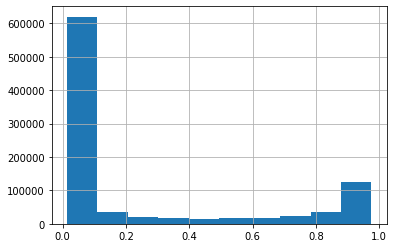

In [27]:
df_sub['prediction'].hist()